In [26]:
import yaml
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os
import seaborn as sns
from datetime import datetime
from scipy.stats import pearsonr
import numpy as np

In [109]:
# Load the YAML file
yaml_file_path = Path("/workspace/data/lchu/hls/jobs/2023-08-11_17-32-52.yaml")  # Replace with the actual path to your YAML file
with open(yaml_file_path, "r") as file:
    yaml_data = yaml.safe_load(file)

# Access the file path from the YAML data
data_file_path = Path(yaml_data["csv_dir"]) / "chip_stats.csv"
val_cloud_path = Path(yaml_data["csv_dir"]) / "val_cloud_catalog.csv"

# Read the .txt file as a CSV using pandas
data_table = pd.read_csv(data_file_path)
val_clouds = pd.read_csv(val_cloud_path)
val_clouds.sort_values(by='fmask_name', inplace=True)

# Display the DataFrame
print(data_table.head())
print(val_clouds.head())

df = pd.concat([data_table.reset_index(drop=True), val_clouds.reset_index(drop=True)], axis=1)
print(df.columns)

        chip_id      chip_x     chip_y   tile  valid_first  valid_second  \
0  chip_002_060 -122.633558  48.932491  10UEV      49903.0       44547.0   
1  chip_021_109 -117.915818  48.565491  11UMP      50094.0       50165.0   
2  chip_026_164 -112.957171  48.949134  12UUV      50176.0       50175.0   
3  chip_027_083 -120.048482  47.830456  10UGU      49294.0       50118.0   
4  chip_031_077 -120.474559  47.502665  10TFT      50167.0       50162.0   

   valid_third  bad_pct_first  bad_pct_second  bad_pct_third  ...   B04 MSE  \
0      49313.0       0.213249        2.841996       0.998485  ...  0.000630   
1      50165.0       0.047832        0.011958       0.009965  ...  0.000603   
2      50176.0       0.000000        0.001993       0.000000  ...  0.000777   
3      49757.0       0.739397        0.033881       0.197305  ...  0.000605   
4      50163.0       0.011958        0.023916       0.023916  ...  0.000517   

    B05 MSE   B07 MSE   B08 MSE  B02 SSIM  B03 SSIM  B04 SSIM  B05 S

In [110]:
df['first_image_date'] = pd.to_datetime(df['first_image_date'])
df['second_image_date'] = pd.to_datetime(df['second_image_date'])
df['third_image_date'] = pd.to_datetime(df['third_image_date'])


# Calculate the difference in days
df['Time Gap'] = (df['third_image_date'] - df['first_image_date']).dt.days
df['Cloud Ratio'] = df['cloud_pct']

print(df.head())
print(df.columns)

        chip_id      chip_x     chip_y   tile  valid_first  valid_second  \
0  chip_002_060 -122.633558  48.932491  10UEV      49903.0       44547.0   
1  chip_021_109 -117.915818  48.565491  11UMP      50094.0       50165.0   
2  chip_026_164 -112.957171  48.949134  12UUV      50176.0       50175.0   
3  chip_027_083 -120.048482  47.830456  10UGU      49294.0       50118.0   
4  chip_031_077 -120.474559  47.502665  10TFT      50167.0       50162.0   

   valid_third  bad_pct_first  bad_pct_second  bad_pct_third  ...  B04 SSIM  \
0      49313.0       0.213249        2.841996       0.998485  ...  0.926394   
1      50165.0       0.047832        0.011958       0.009965  ...  0.858622   
2      50176.0       0.000000        0.001993       0.000000  ...  0.891321   
3      49757.0       0.739397        0.033881       0.197305  ...  0.863180   
4      50163.0       0.011958        0.023916       0.023916  ...  0.927810   

   B05 SSIM  B07 SSIM  B08 SSIM                fmask_name cloud_pct 

             Overall SSIM Overall MSE Mask Ratio Cloud Ratio  Time Gap
Overall SSIM       1.0***     -0.7***    -0.8***    -0.78***  -0.17***
Overall MSE       -0.7***      1.0***    0.31***     0.35***   0.43***
Mask Ratio        -0.8***     0.31***     1.0***     0.94***      0.02
Cloud Ratio      -0.78***     0.35***    0.94***      1.0***      0.02
Time Gap         -0.17***     0.43***       0.02        0.02    1.0***
              Overall SSIM  Overall MSE  Mask Ratio  Cloud Ratio  Time Gap
Overall SSIM      1.000000    -0.695195   -0.795112    -0.781697 -0.170175
Overall MSE      -0.695195     1.000000    0.305188     0.349087  0.425347
Mask Ratio       -0.795112     0.305188    1.000000     0.935021  0.016083
Cloud Ratio      -0.781697     0.349087    0.935021     1.000000  0.023802
Time Gap         -0.170175     0.425347    0.016083     0.023802  1.000000


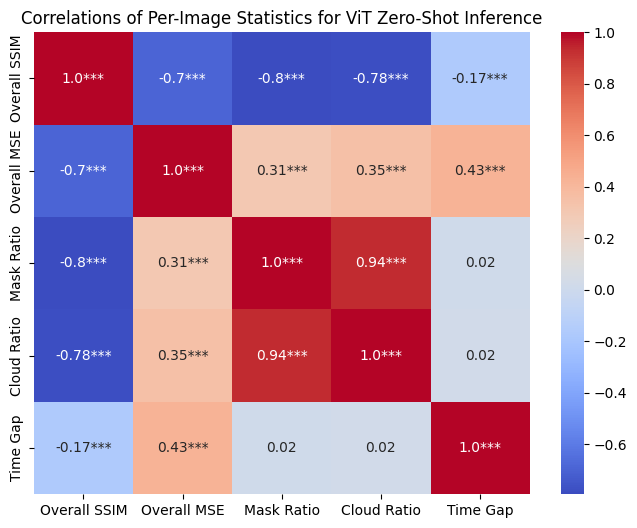

In [111]:
df = df[['Overall SSIM', 'Overall MSE',
       'Mask Ratio', 'Cloud Ratio', 'Time Gap']]


rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
significant_correlations = rho.round(2).astype(str) + p
print(significant_correlations)
print(rho)



# Create the heatmap of p-values
plt.figure(figsize=(8, 6))
sns.heatmap(rho, annot=significant_correlations, fmt='', cmap="coolwarm")  # Format to 3 decimal places
plt.title('Correlations of Per-Image Statistics for ViT Zero-Shot Inference')
plt.show()


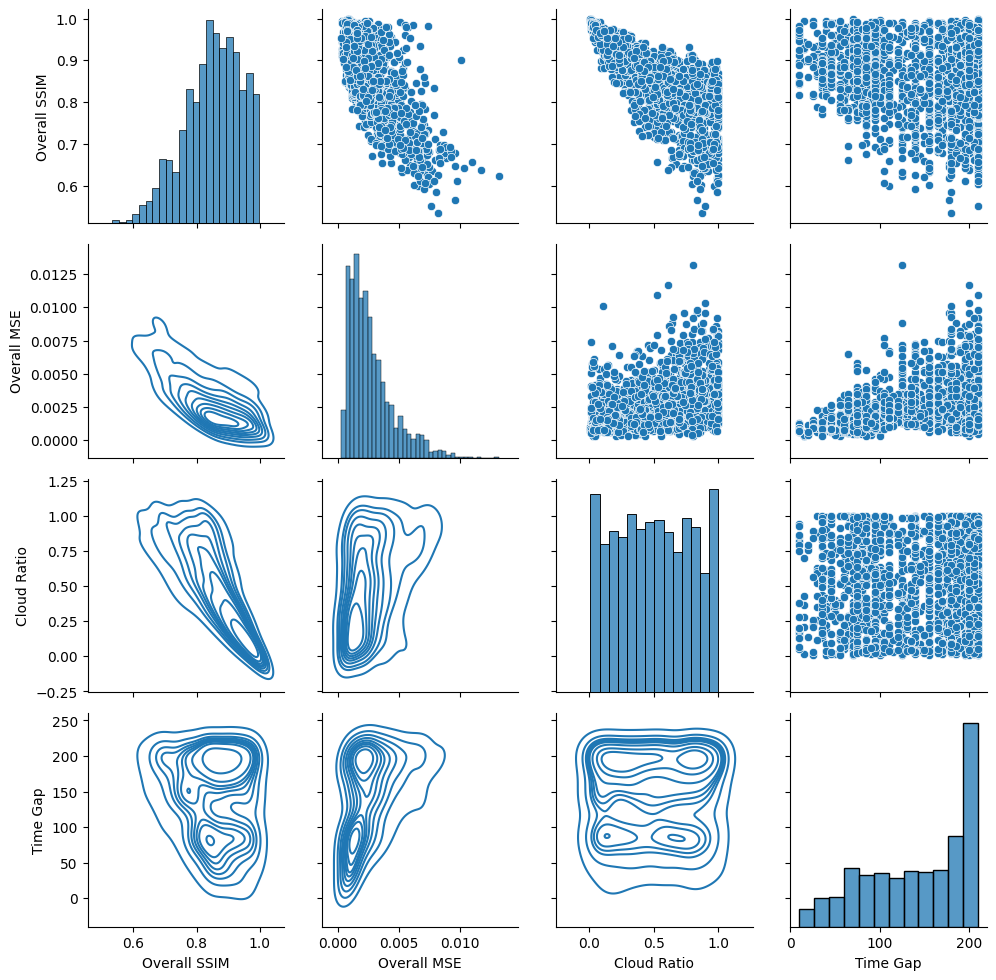

In [112]:
df = df[['Overall SSIM', 'Overall MSE', 'Cloud Ratio', 'Time Gap']]
g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot)
plt.show()